<a href="https://colab.research.google.com/github/HoanChan/TableVision/blob/main/borderless_table_detection.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

In [1]:
#@title Cài đặt kiểm tra môi trường và tải mã nguồn để lấy dữ liệu
# Kiểm tra hiện tại có phải đang ở trong colaboratory hay không
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !git clone https://github.com/HoanChan/TableVision.git TableVision
    %cd TableVision
else:
    print("Running on Local")
prePath = "/content/TableVision/" if IN_COLAB else ""

Running on Local


In [2]:
from utils.ocr import *

detector = init_VietOCR()

Đã cài đặt thư viện nhận diện văn bản


/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model weight /tmp/vgg_seq2seq.pth exsits. Ignore download!


<Figure size 1000x2000 with 0 Axes>

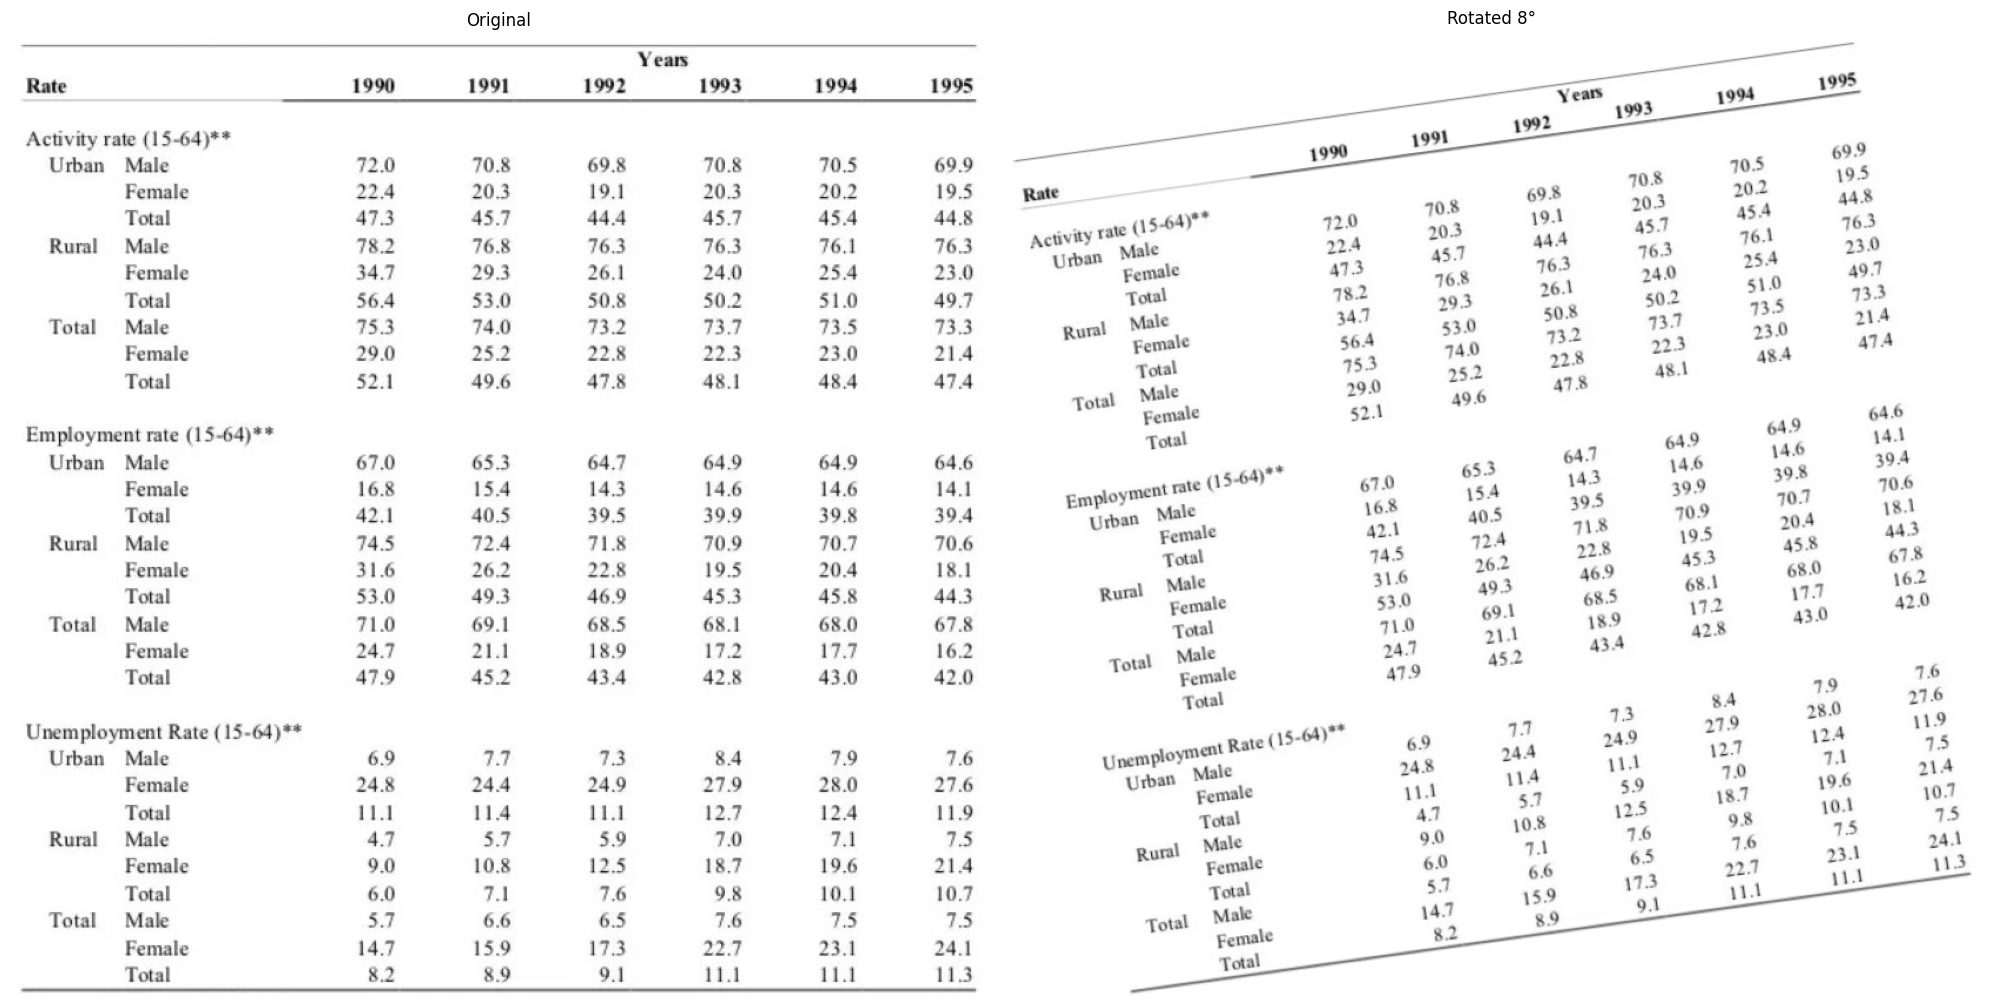

In [3]:
from utils.cv import *
from matplotlib import pyplot as plt
import cv2
import random
from detection.borderless_table_detection import *

image_path = prePath + "sample/no4.jpg"
image = cv2.imread(image_path)
angle = random.randint(-30, 30)
rotated_image = rotate_image(image, angle)
# thiết lập kích thước hiển thị ảnh
plt.figure(figsize=(10, 20))
# hiển thị ảnh gốc và ảnh đã xoay
display_images_with_labels([(image, "Original"), (rotated_image, f"Rotated {str(angle)}°")], (1, 2), show_axis=False)

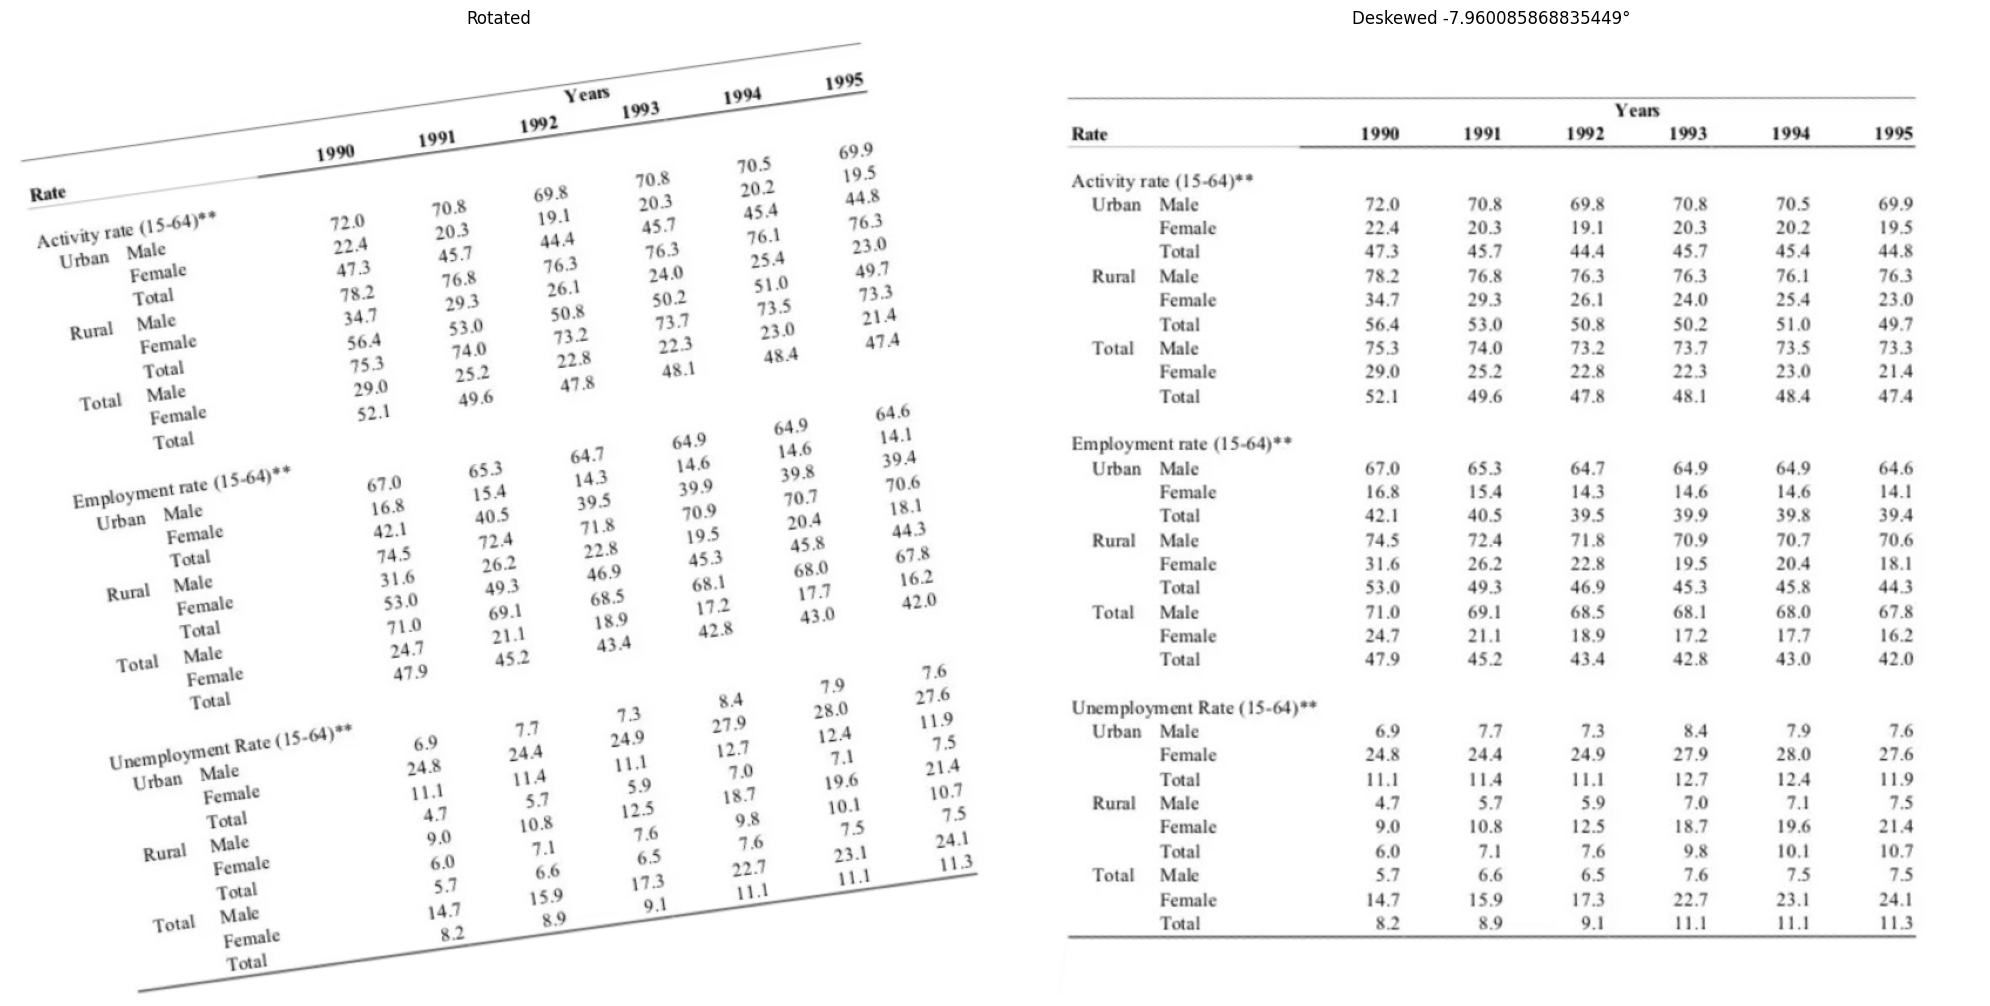

In [4]:
image_deskew, calc_angle = deskew_image(rotated_image)
display_images_with_labels([(rotated_image, "Rotated"), (image_deskew, f"Deskewed {str(calc_angle)}°")], (1, 2), show_axis=False)

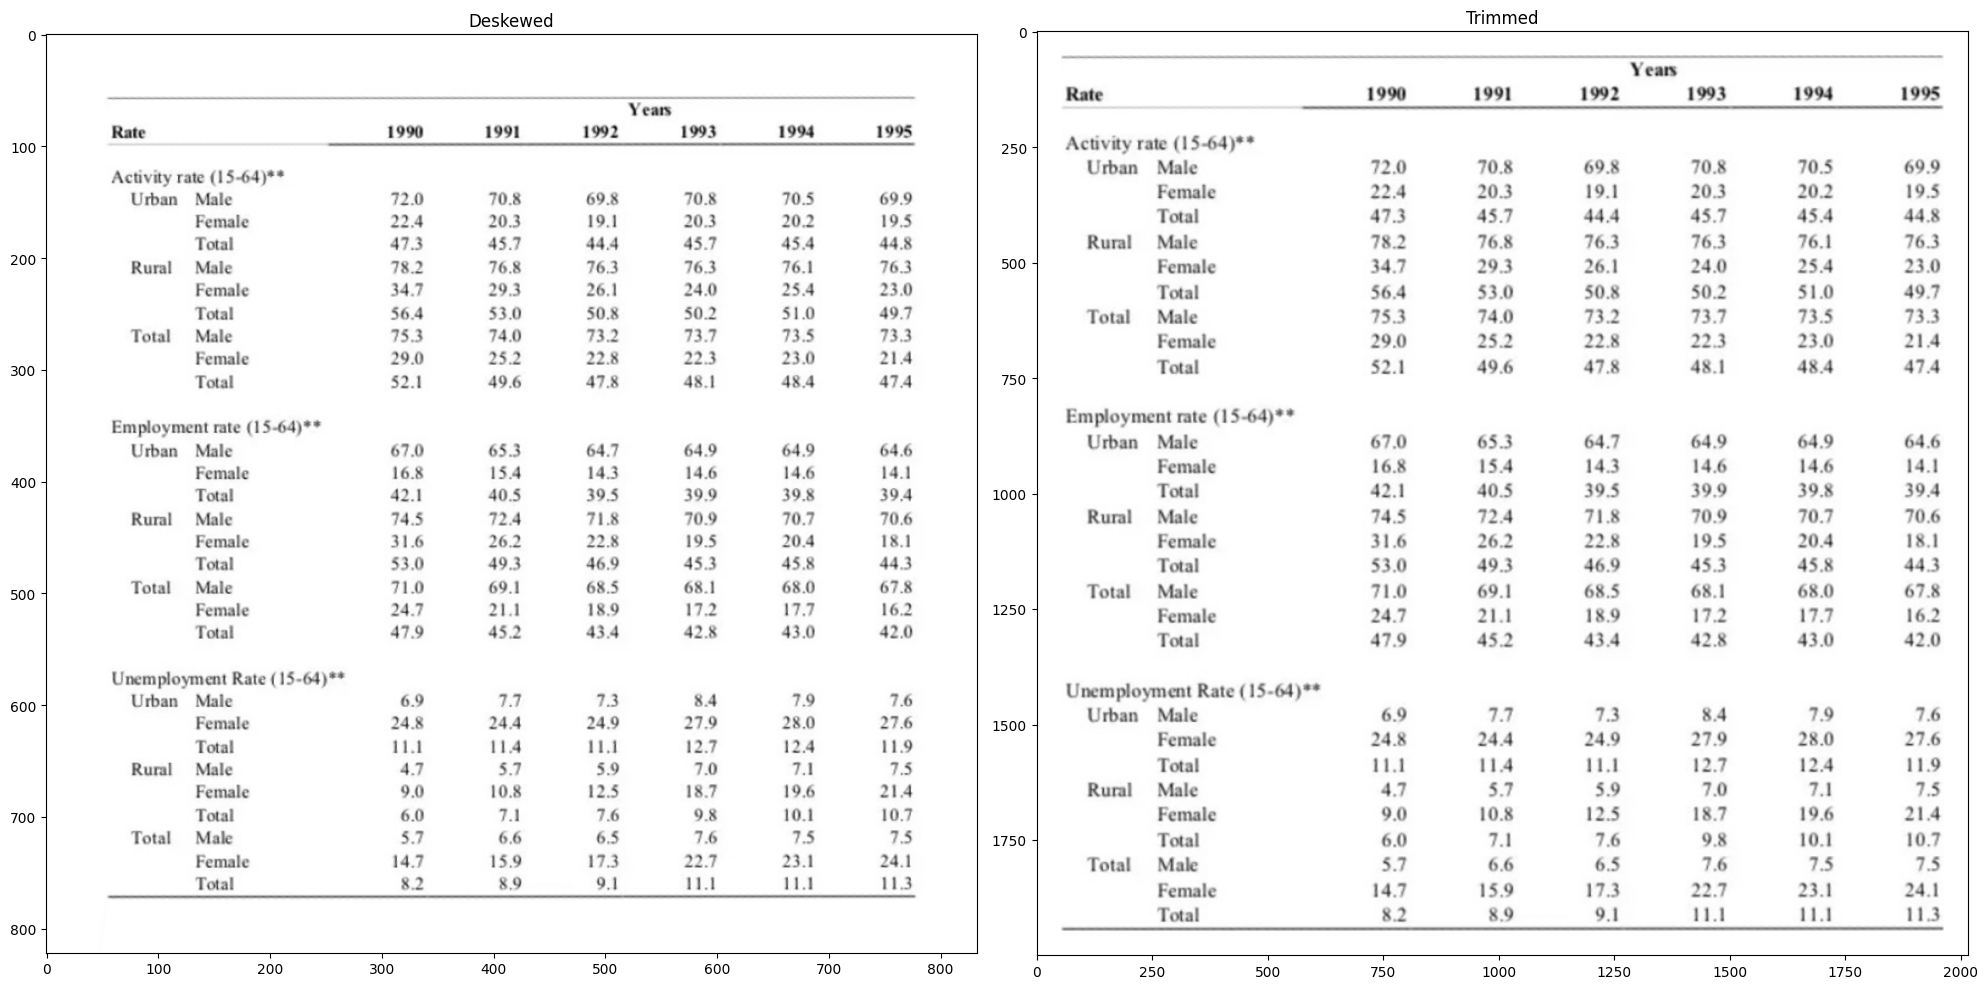

In [5]:
image_ok = trim_white(image_deskew)
display_images_with_labels([(image_deskew, "Deskewed"), (image_ok, "Trimmed")], (1, 2), show_axis=True)

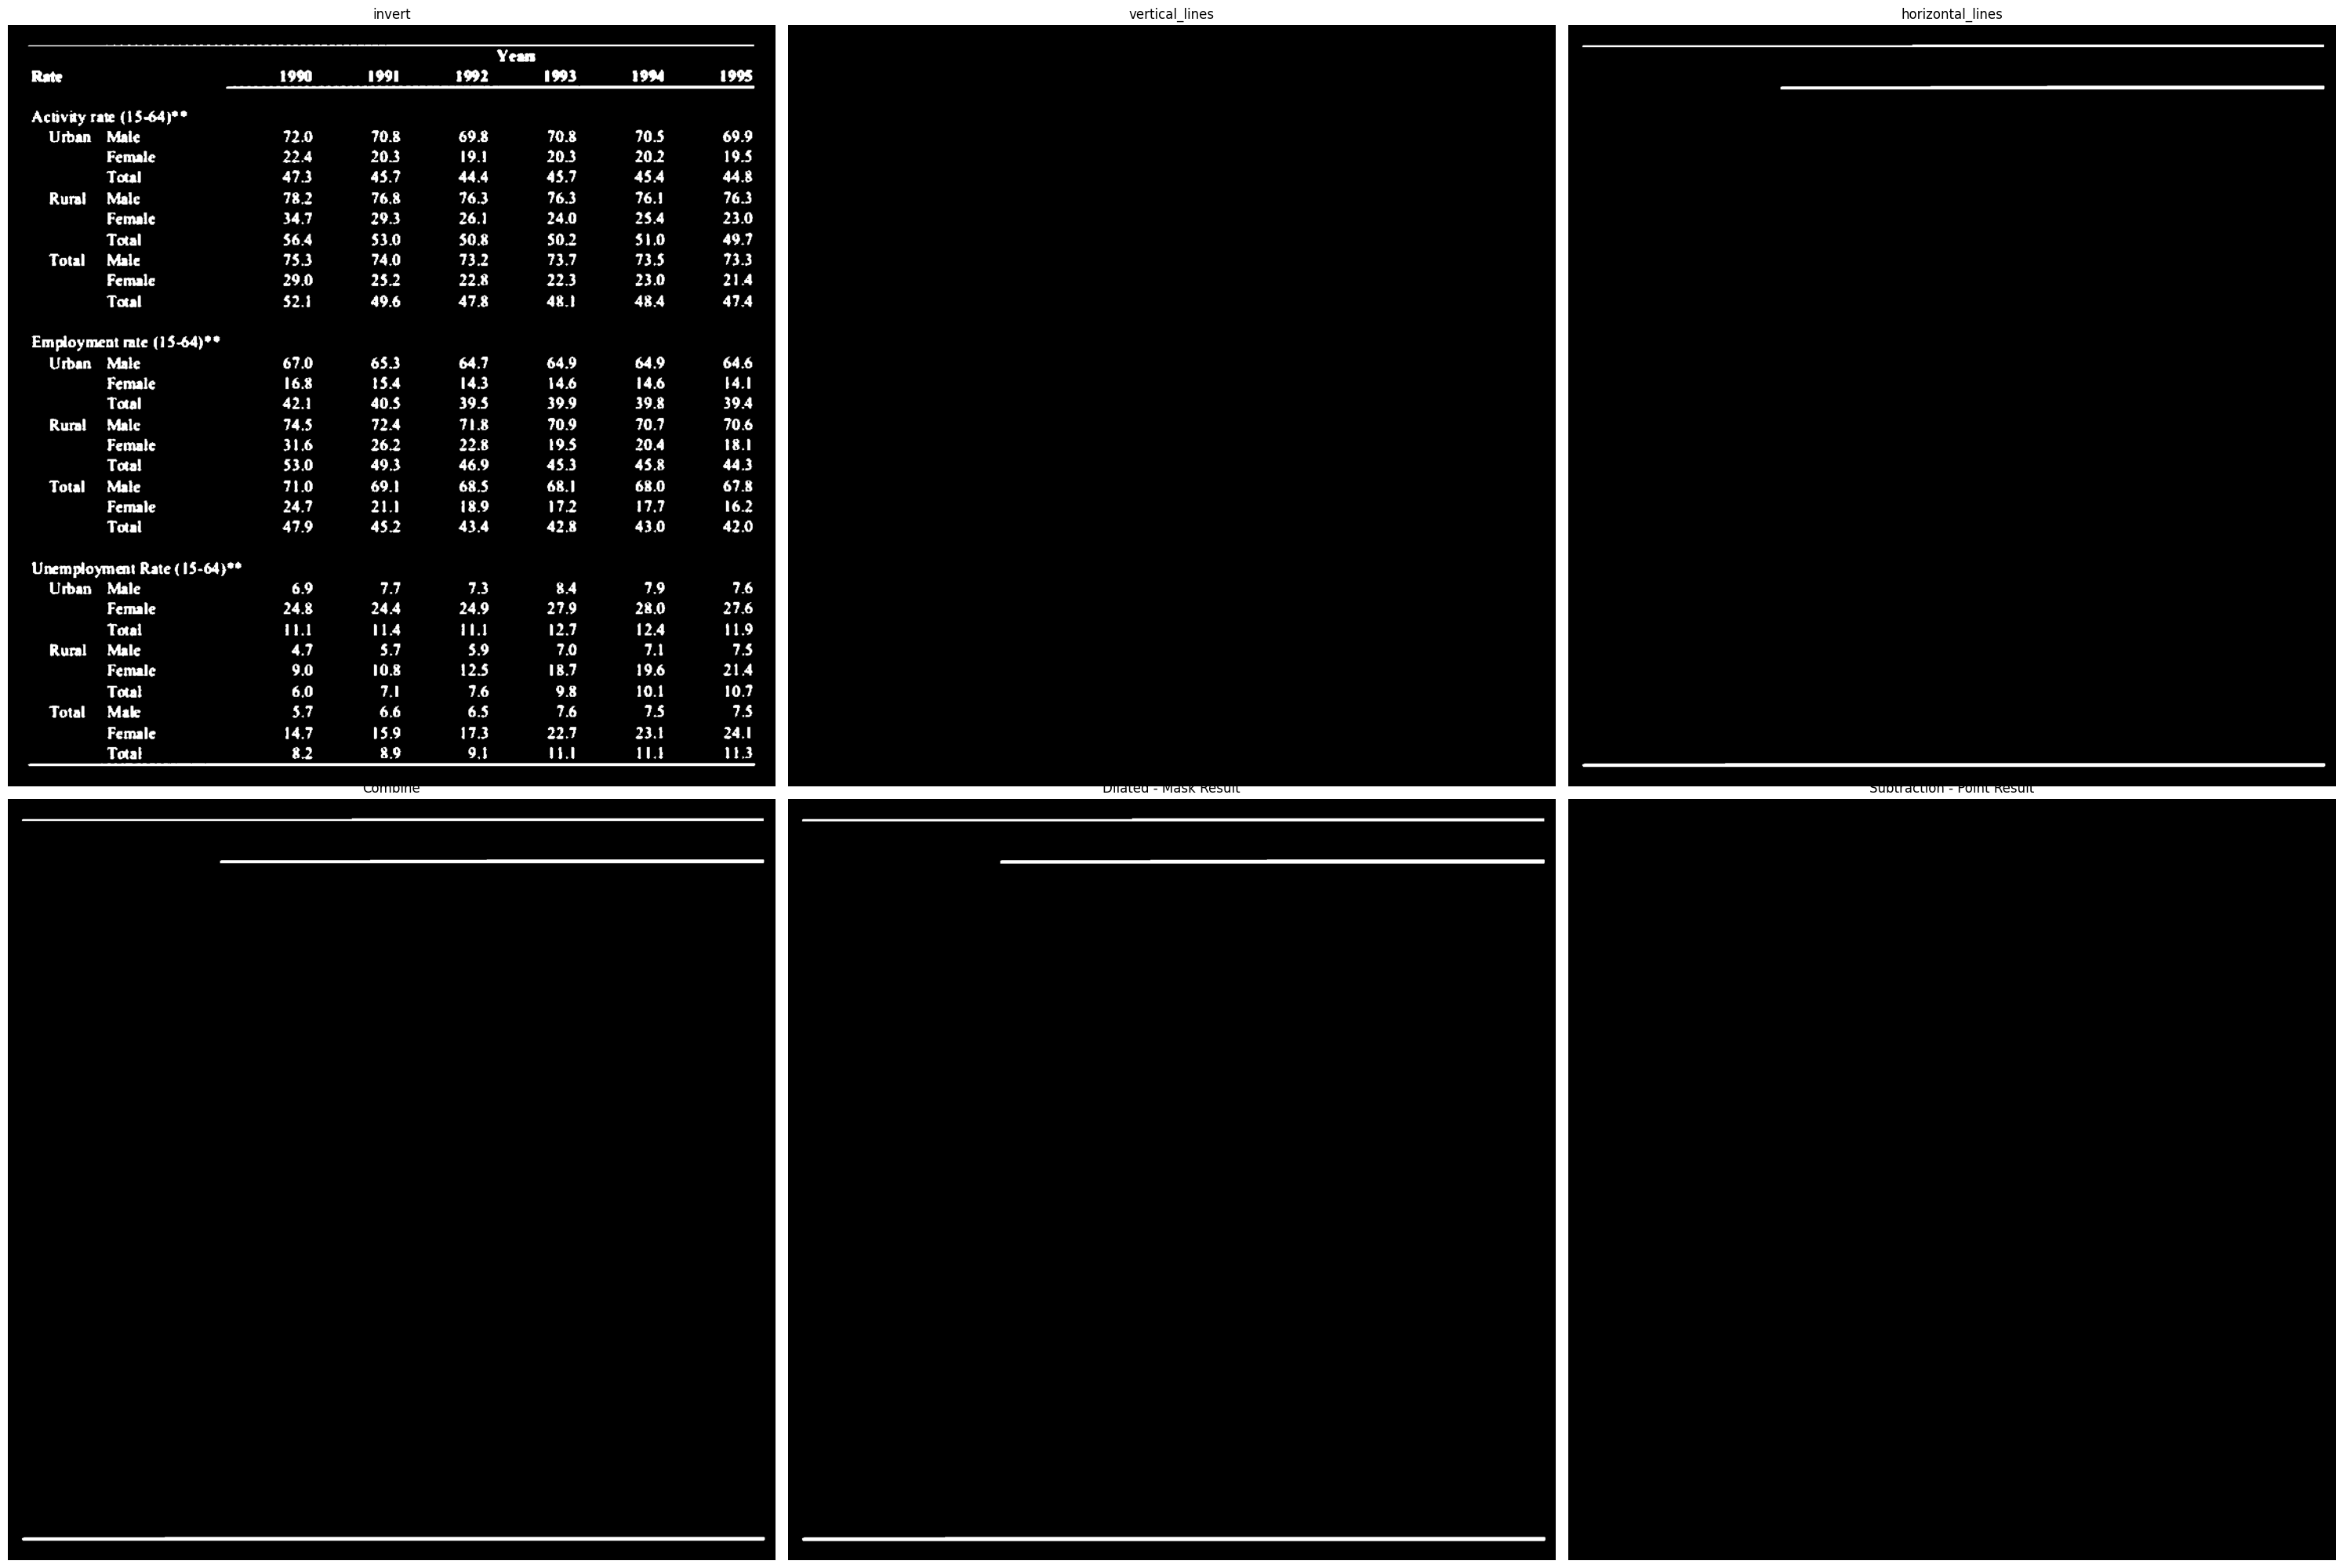

In [6]:
mask, dots, outImag = find_Lines(image_ok)
num_cols = 3
num_rows = len(outImag) // num_cols if len(outImag) % num_cols == 0 else len(outImag) // num_cols + 1
display_images_with_labels(outImag, (num_rows, num_cols), show_axis=False)

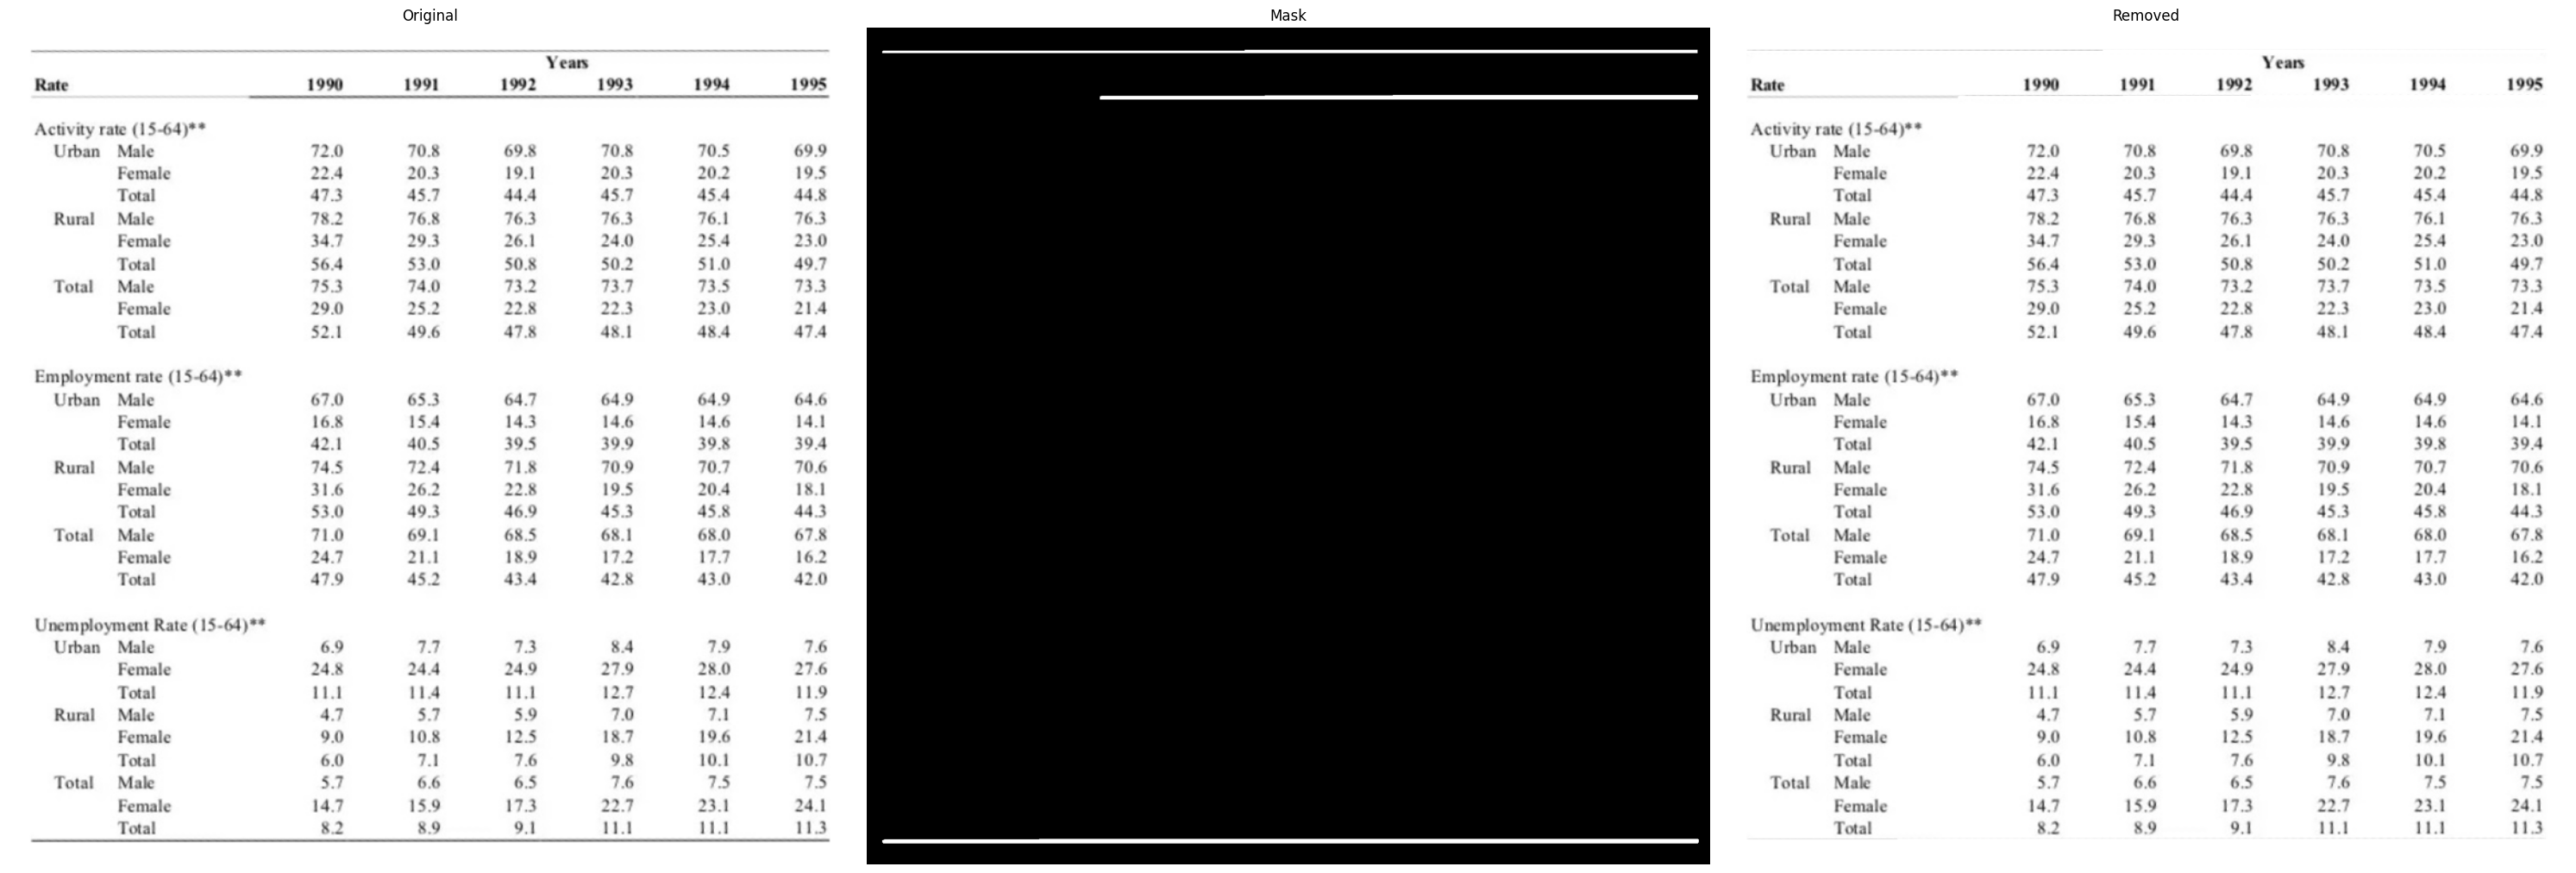

In [7]:
image_removed = remove_regions(image_ok, mask)
display_images_with_labels([(image_ok, "Original"), (mask,'Mask'), (image_removed, "Removed")], (1, 3), show_axis=False)

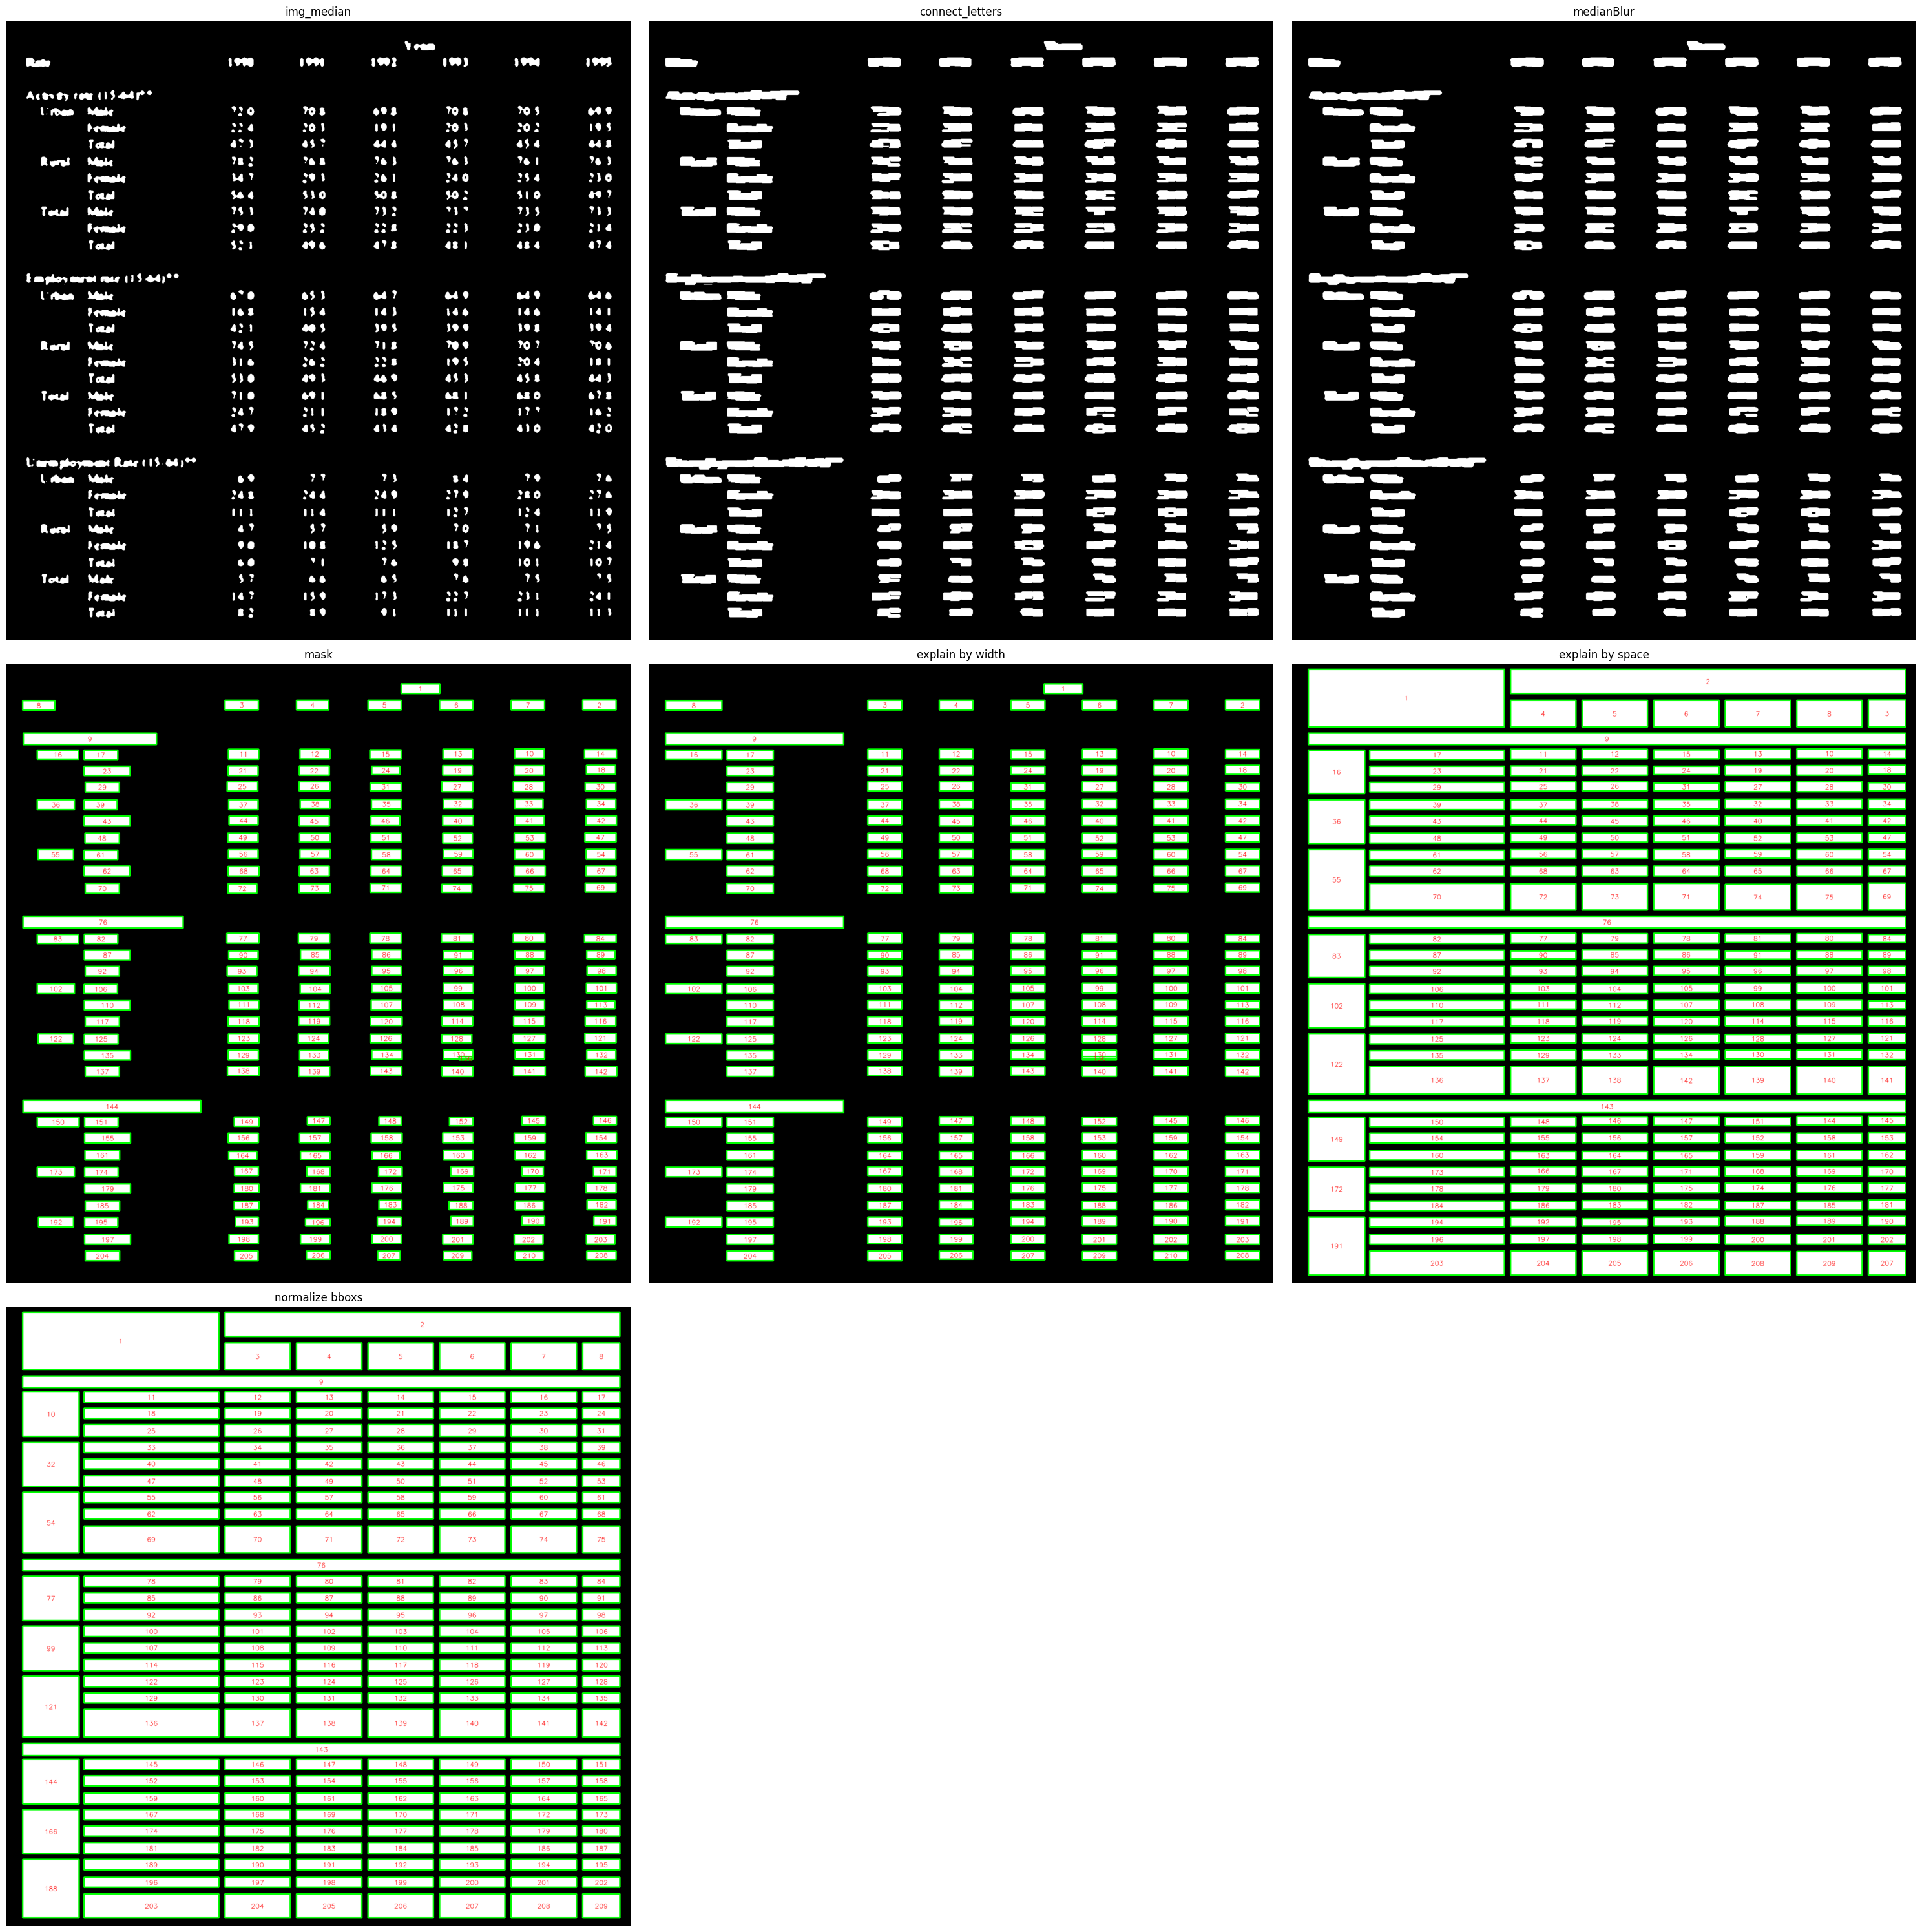

In [8]:
bboxs, mask, outImag = find_Cells(image_removed)
num_cols = 3
num_rows = len(outImag) // num_cols if len(outImag) % num_cols == 0 else len(outImag) // num_cols + 1
display_images_with_labels(outImag, (num_rows, num_cols), show_axis=False)

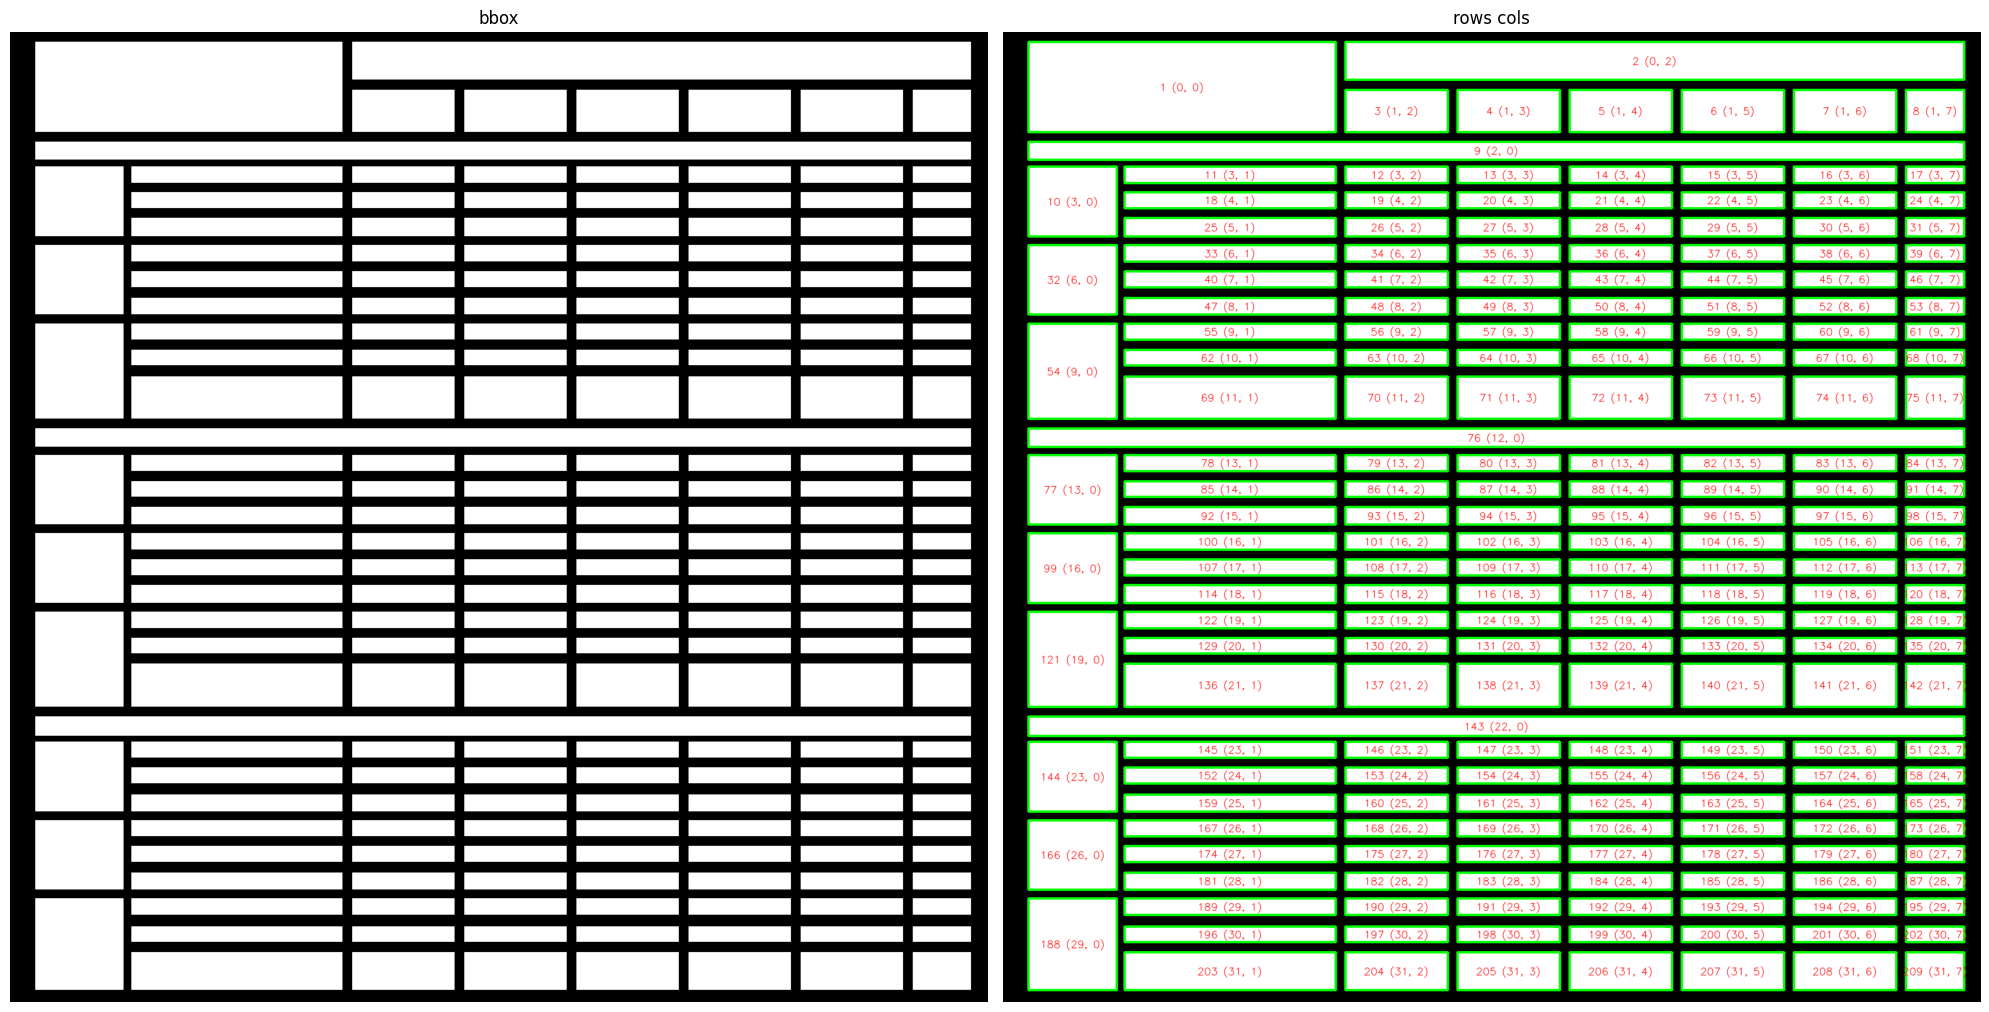

In [9]:
boxs = bboxs
cols = split_box_rows_columns(boxs, mode = 'col')       
rows = split_box_rows_columns(boxs, mode = 'row')
box_indexs = [getbox_index(box, rows, cols) for box in boxs]
new_mask = create_mask_from_bboxs(image_removed, boxs)
img_rows_cols = draw_bboxs(new_mask, boxs, lambda x: str(x) + ' '+ str(box_indexs[x-1]))
display_images_with_labels([(mask,'bbox'),(img_rows_cols, 'rows cols')], (1, 2), show_axis=False)

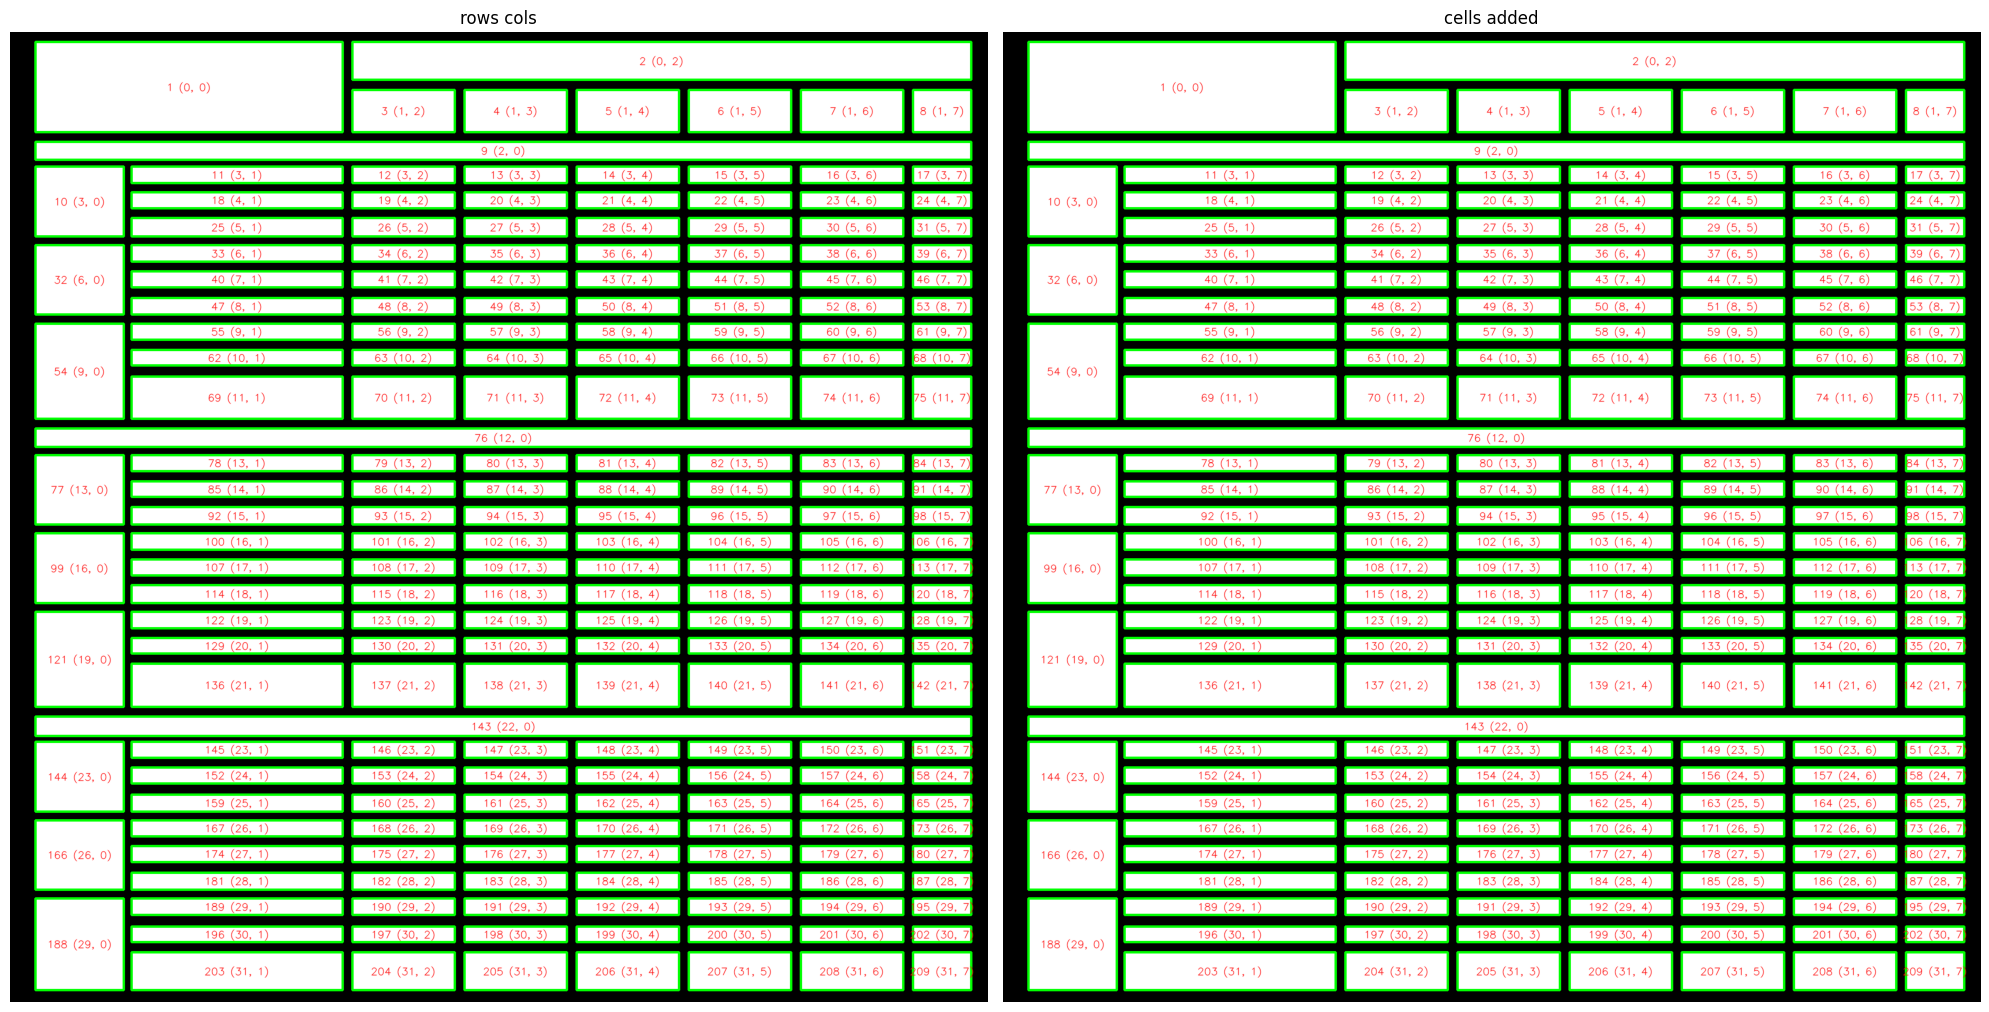

In [10]:
boxs, rows, cols, box_indexs = add_missing_cells(boxs, rows, cols, box_indexs)
new_mask = create_mask_from_bboxs(image_removed, boxs)
img_cells_added = draw_bboxs(new_mask, boxs, lambda x: str(x) + ' '+ str(box_indexs[x-1]))
display_images_with_labels([(img_rows_cols, 'rows cols'),(img_cells_added, 'cells added')], (1, 2), show_axis=False)

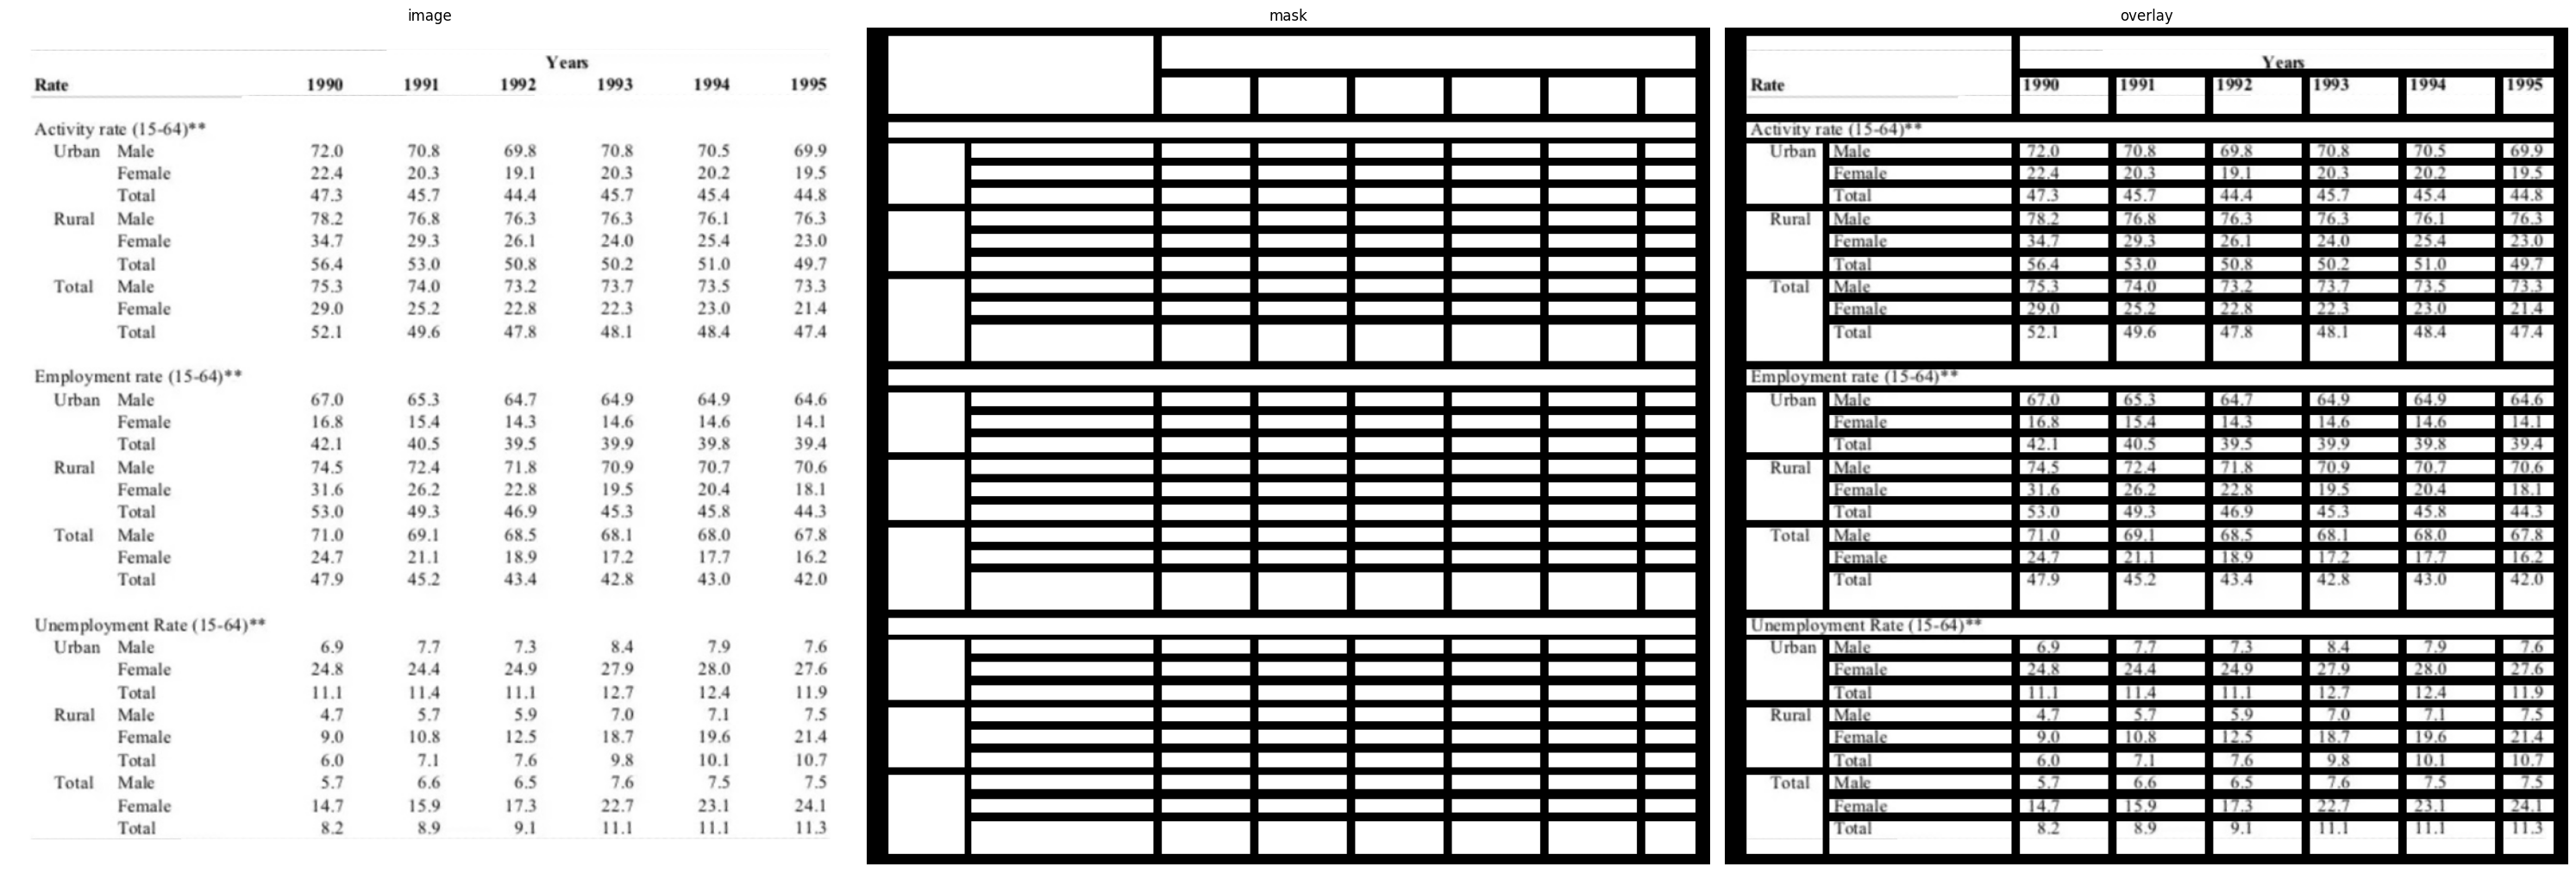

In [11]:
overlay_mask = cv2.cvtColor(new_mask, cv2.COLOR_GRAY2BGR) 
overlay_img = cv2.bitwise_and(image_removed, overlay_mask)
display_images_with_labels([(image_removed, 'image'),(new_mask, 'mask'),(overlay_img, 'overlay')], (1, 3), show_axis=False)

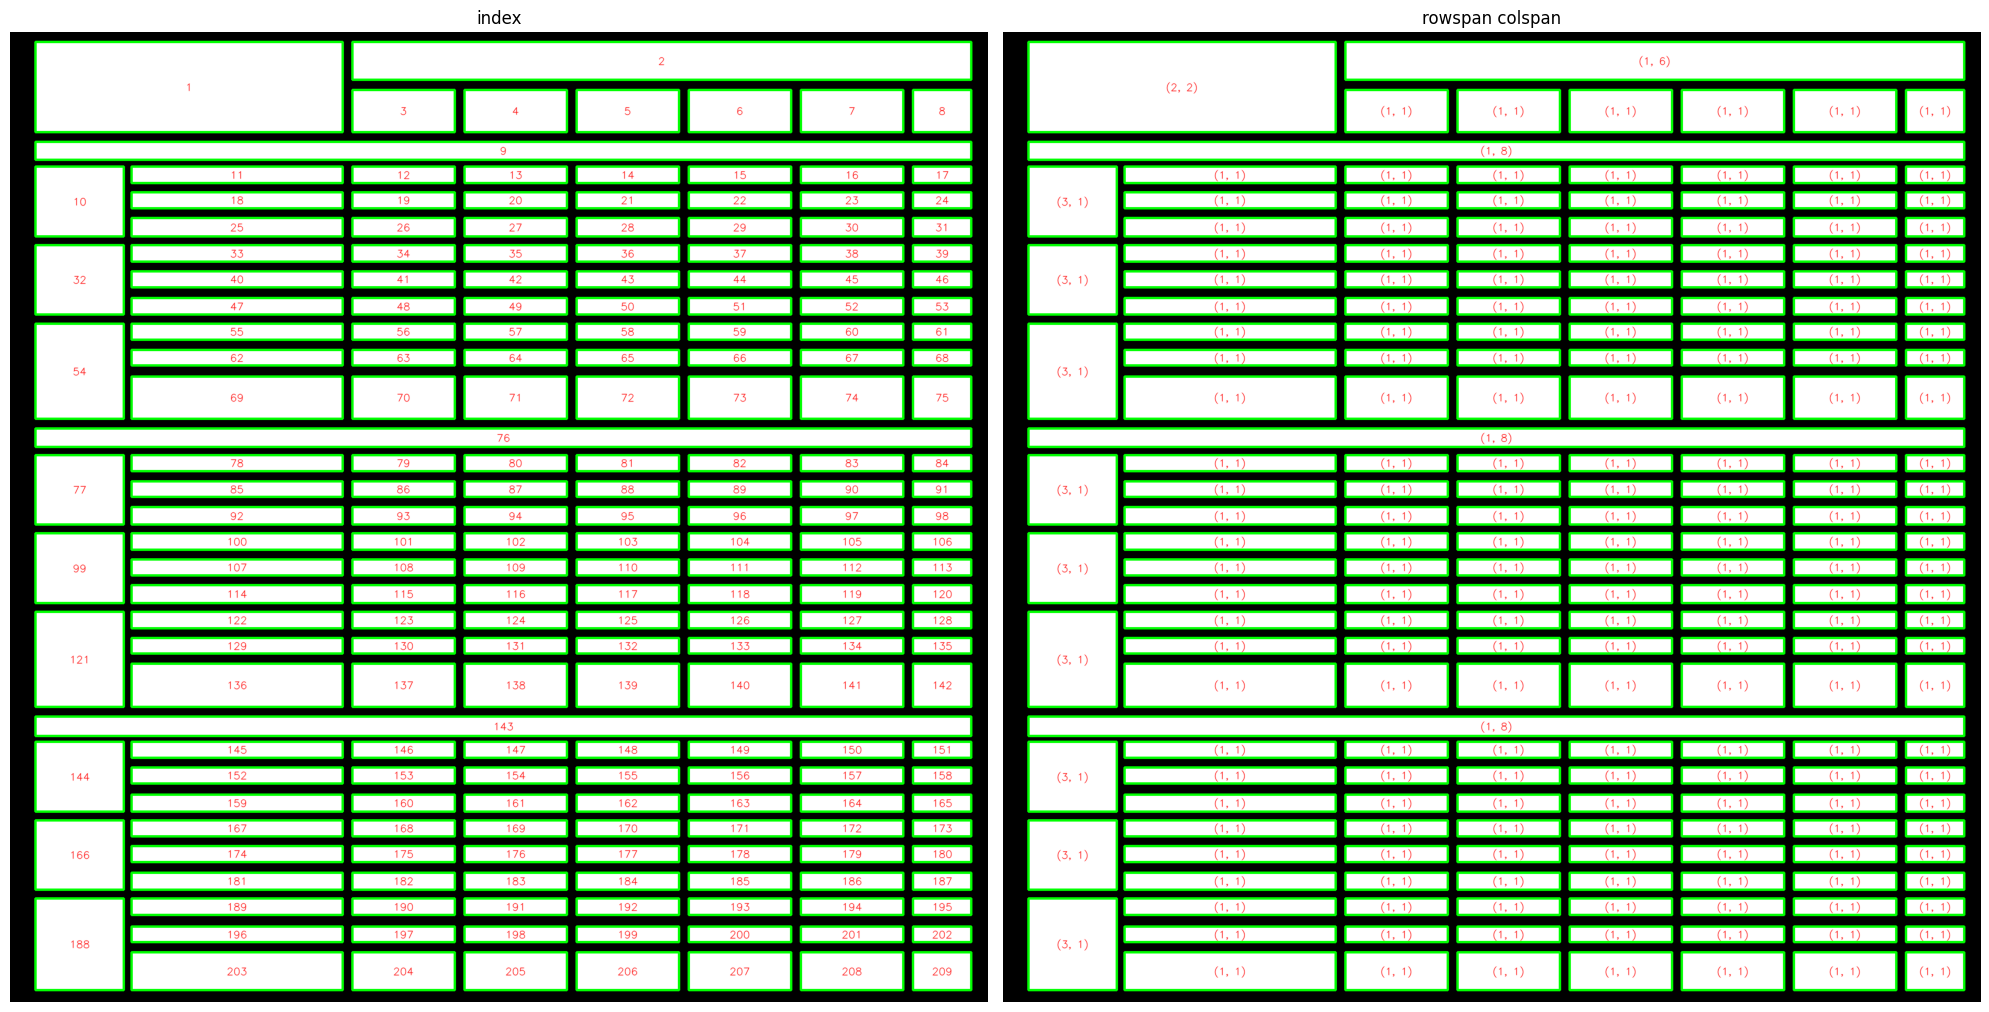

In [12]:
matrix = createSpanMatrix(rows, cols, box_indexs, bboxs)
img_index= draw_bboxs(new_mask, boxs)
img_span = draw_bboxs(new_mask, boxs, lambda x: str(matrix[box_indexs[x-1][0]][box_indexs[x-1][1]][1:]))
display_images_with_labels([(img_index, 'index'),(img_span, 'rowspan colspan')], (1, 2), show_axis=False)

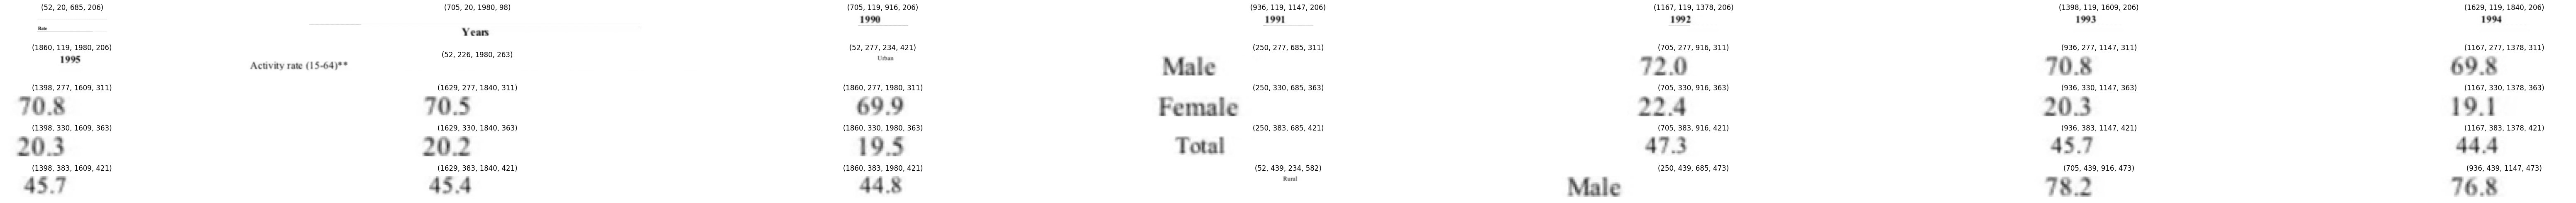

In [13]:
cells = createCells(boxs, box_indexs, matrix)
cells_imgs = createCell_img(cells, image_removed)

display_images_with_labels(cells_imgs[:35], layout = (5, 7), size = (10, 1), show_axis=False)

Male


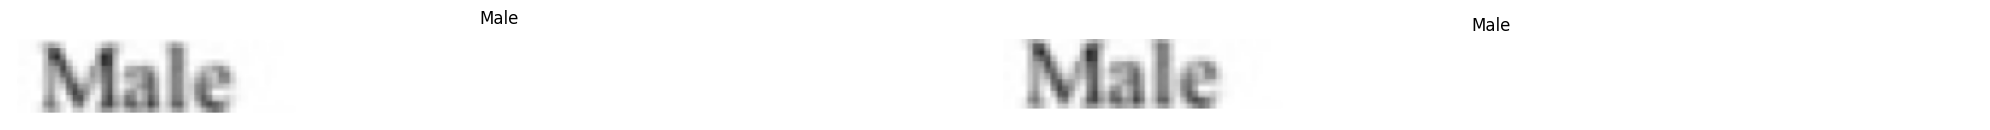

In [14]:
from utils.ocr import detectText
img = cells_imgs[54][0]
text, lines = detectText(img, detector)
print(text)
display_images_with_labels([(img, text)] + list(zip(lines, text.split('\n'))), (1, len(lines)+1), show_axis=False)

In [15]:
texts = []
for cell in cells_imgs:
  img, bbox = cell
  text, lines = detectText(img, detector)
  texts += [text]

print(texts, sep='\n')

['Rate', 'Year', '1990', '1991', '1992', '1993', '1994', '1995', 'Activity rate (15-641000000000000000000000010', 'Urban', 'Malconstrationalize', '72.0', '001000000100', '001000000100', 'TRANSTRATES', 'TO', '610', 'Female', '001000000100\nAntication', '20.0', '19.1', '20.0', '2010\nCONTERSIONS', '1950', 'Total Hammers', '4730', '45.700', '44.4', '451700000019', '45.000000', '44.8', 'Rural', 'Malconsentionalize', 'DISCONTERS\n70 1000', '001000000100', 'CONTERSIONS\nTRANS', 'CONTERSENTIONALIZES\nTRANSTRATION', '1661000000', 'CONTERS\nTRANS', 'Femalesses', '14.1000000001000', '1000', '26.1000000', '24.0', '1000000001001\n001000000100', '11.0', 'Totalonically\n0010000001001', '50.000000', 'STATES', 'STURES', '5010000001000', '51000000001000', '4977', '', 'Male', '001000000100', 'TRINGER', '001000000100\n0010000001001', 'CONTERSIONALIZES\nINTERSTATIONS', 'INTERSING', 'CONTERSION\nCONTERS\nCONTERSION\nSTATES', 'Female', '10 000000001000', 'TRANS\nTRANS', '11000000010', 'ANTERCOMPERSIONS\n001

In [16]:
cells_imgs = []
for i in range(len(cells)):
  cells[i]['cell text'] = texts[i]
html = cells_to_html(cells).replace('<thead>','<tr>').replace('</thead>','</tr>').replace('\n',"<br>")
html

'<table><tr><th colspan="2" rowspan="2">Rate</th><th colspan="6">Year</th></tr><tr><td>1990</td><td>1991</td><td>1992</td><td>1993</td><td>1994</td><td>1995</td></tr><tr><td colspan="8">Activity rate (15-641000000000000000000000010</td></tr><tr><td rowspan="3">Urban</td><td>Malconstrationalize</td><td>72.0</td><td>001000000100</td><td>001000000100</td><td>TRANSTRATES</td><td>TO</td><td>610</td></tr><tr><td>Female</td><td>001000000100<br>Antication</td><td>20.0</td><td>19.1</td><td>20.0</td><td>2010<br>CONTERSIONS</td><td>1950</td></tr><tr><td>Total Hammers</td><td>4730</td><td>45.700</td><td>44.4</td><td>451700000019</td><td>45.000000</td><td>44.8</td></tr><tr><td rowspan="3">Rural</td><td>Malconsentionalize</td><td>DISCONTERS<br>70 1000</td><td>001000000100</td><td>CONTERSIONS<br>TRANS</td><td>CONTERSENTIONALIZES<br>TRANSTRATION</td><td>1661000000</td><td>CONTERS<br>TRANS</td></tr><tr><td>Femalesses</td><td>14.1000000001000</td><td>1000</td><td>26.1000000</td><td>24.0</td><td>10000000

In [17]:
from IPython.display import display, HTML
new_html = createHTML(image_path, html, useBase64=IN_COLAB)
display(HTML(new_html))

In [18]:
from IPython.display import display, HTML
from detection.borderless_table_detection import recognize
display(HTML(recognize(prePath + "sample/xx2.jpg", detector, useBase64=IN_COLAB)))

In [19]:
display(HTML(recognize(prePath + "sample/no1.jpg", detector, useBase64=IN_COLAB)))

In [20]:
display(HTML(recognize(prePath + "sample/no2.jpg", detector, useBase64=IN_COLAB)))

In [21]:
display(HTML(recognize(prePath + "sample/no3.jpg", detector, useBase64=IN_COLAB)))

In [22]:
display(HTML(recognize(prePath + "sample/no4.jpg", detector, useBase64=IN_COLAB)))

In [23]:
display(HTML(recognize(prePath + "sample/no5.jpg", detector, useBase64=IN_COLAB)))

In [24]:
display(HTML(recognize(prePath + "sample/no6.jpg", detector, useBase64=IN_COLAB)))